# Trabalho Prático 2 - POS Tagging
## Matheus Henrique do Nascimento Nunes - 2013007668
### Processamento de Linguagem Natural - NLP 2018

O objetivo deste trabalho prático é realizar a tarefa de Part-of-Speech (POS) Tagging para a Língua Portuguesa em um corpus produzido pelo grupo NILC do ICMC USP. O corpus pode ser encontrado no seguinte endereço: http://nilc.icmc.usp.br/macmorpho/macmorpho-v3.tgz . Um manual contendo informações sobre o dataset pode ser encontrado no seguinte endereço: http://nilc.icmc.usp.br/macmorpho/macmorpho-manual.pdf .

## Contextualização

### POS Tagging

POS (Part-Of-Speech) Tagging corresponde à tarefa de se ler um texto (composto de $n$ palavras $w_1, w_2, ..., w_n$) e assinalar a cada uma das palavras $w_i$ uma _tag_ $t_i$, $i \in \{1, 2, ..., n\}$ que indica o tipo gramatical da palavra (substantivo, adjetivo, preposição, nome próprio, etc.). 

### _Tags_

O conjunto de etiquetas (_tags_) presentes no _corpus_ é a seguinte:

* _ART_: Artigo
* _ADJ_: Adjetivo
* _N_: Nome
* _NPROP_: Nome Próprio
* _NUM_: Numeral
* _PROADJ_: Pronome Adjetivo
* _PROSUB_: Pronome Substantivo
* _PROPESS_: Pronome Pessoal
* _PRO-KS_: Pronome Conectivo Subordinativo
* _PRO-KSREL_: Pronome Conectivo Subordinativo Relativo
* _ADV_: Advérbio 
* _ADV-KS_ Advérbio Conectivo Subordinativo
* _ADV-KS-REL_ Advérbio Relativo Subordinativo
* _KC_: Conjunção Coordenativa
* _KS_: Conjunção Subordinativa
* _PREP_: Preposição 
* _IN_: Interjeição 
* _V_: Verbo 
* _VAUX_: Verbo Auxiliar 
* _PCP_: Particípio 
* _PDEN_: Palavra Denotativa 
* _CUR_: Símbolo de Moeda Corrente 
* _PU_: Pontuação

Ao total são 26 etiquetas únicas, que caracterizam cada token presente no _corpus_. Uma seção de etiquetas complementares é apresentada no manual [[1]](http://nilc.icmc.usp.br/macmorpho/macmorpho-manual.pdf), mas estas etiquetas não foram encontradas nos datasets _providos_.

## Metodologia

Esta seção possui o objetivo de descrever a sequência de passos necessária para se realizar a tarefa de _POS Tagging_. Os códigos utilizados em cada parte serão apresentados também.

###  Processamento do _corpus_

Inicialmente, é necessário realizar um processamento nos arquivos que compõem o _corpus_. O _corpus_ é dividido em três arquivos:

* _macmorpho__train.txt_ - Arquivo para treinamento do modelo
* _macmorpho__test.txt_ - Arquivo de teste para o modelo
* _macmorpho__dev.txt_ - Arquivo de validação do modelo

Todos os três arquivos contém um número fixo de linhas, e cada linha contém uma sequência de palavras seguidas por suas _tags_, no formato $w_i\_t_i$ (palavra $w_i$ separada por um $\_$ de sua _tag_ $t_i$). Segue abaixo um exemplo de uma linha dos arquivos:


In [1]:
# Imports
import keras
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
from os import getcwd
from os.path import join
from os.path import exists
import matplotlib.pyplot as plt
from tensorflow.train import Saver
from keras.utils import to_categorical
from gensim.models import KeyedVectors
from sklearn.metrics import classification_report
sns.set()
%matplotlib inline

Using TensorFlow backend.


In [2]:
# Useful paths for this assignment
paths = {
    # Directory paths
    'log_dir': join(getcwd(), 'tp2_data', 'logs'),
    'data_dir': join(getcwd(), 'tp2_data', 'data'),
    'model_dir': join(getcwd(), 'tp2_data', 'models'),
    # Corpus paths
    'dev_dataset': join(getcwd(), 'macmorpho-v3/macmorpho-dev.txt'),
    'test_dataset': join(getcwd(), 'macmorpho-v3/macmorpho-test.txt'),
    'train_dataset': join(getcwd(), 'macmorpho-v3/macmorpho-train.txt'),
    # Word2Vec paths
    'word2vec_txt': join(getcwd(), 'tp2_data', 'data', 'skip_s100.txt'),
    'word2vec_weights': join(getcwd(), 'tp2_data', 'models', 'weights_word2vec.p'),
    'word2vec_pickle': join(getcwd(), 'tp2_data', 'models', 'word2vec_model_skipgram_100.p'),
}

In [3]:
# Line example from the corpus file
with open(paths['train_dataset'], 'r') as f:
    print(f.readline())

Jersei_N atinge_V média_N de_PREP Cr$_CUR 1,4_NUM milhão_N na_PREP+ART venda_N da_PREP+ART Pinhal_NPROP em_PREP São_NPROP Paulo_NPROP ._PU



Dá-se início então ao processamento real do corpus. As atividades realizadas serão as seguintes, nesta ordem:

1. Os arquivos serão lidos na memória
2. Cada arquivo será representado por uma lista de linhas, e cada linha de cada arquivo será representado por uma lista de _tokens_
3. Os _tokens_ de cada arquivo são compostos de palavras e tags: Será separado as tags das palavras em cada arquivo, gerando duas listas para cada arquivo
4. Um dicionário contendo todas as _tags_ únicas de todos os arquivos será criado
5. Um sistema de numeração para estas _tags_ também será criado, no mesmo dicionário
6. Um tamanho padrão será definido para todas as sentenças: sentenças menores do que este tamanho serão _padded_ (preenchidas com uma _tag_ que indica preenchimento), sentenças menores do que este tamanho serão cortadas
7. As palavras do arquivo serão convertidas em uma representação vetorial distribuída, utilizando um modelo Word2Vec
8. As _tags_ do arquivo serão substituídas pelos seus indices numéricos, e em seguida convertidas em uma representação _One-Hot Encoded_ utilizando o __keras.utils.to_categorical__

Seguem algumas definições de funções que serão utilizadas nesta etapa de processamento do texto:


In [4]:
# Useful text processing methods
def list_flatten(l):
    """ Flatten list of lists: returns contents in single list
    Arguments:
        l {list} -- List of lists of elements
    Returns:
        l {list} -- Flat list of elements
    """
    return [item for sublist in l for item in sublist]


def read_file_into_list(filepath):
    """ Read text file into list of lists of tokens
    Arguments:
        filepath {str} -- Path to file
    Returns:
        raw_text {list} -- List of lists of tokens
    """
    raw_text = []
    with open(filepath, 'r') as f:
        for line in f:
            raw_text.append(line.split())
    return raw_text


def get_text_words(text):
    """ Separate words from tags in text
    Arguments:
        text {list} -- Text file: list of lists of tokens
    """
    return [list(map(lambda word: word.split('_')[0].lower(),
                     sentence))
            for sentence in text]


def get_text_tags(text):
    """ Separate tags from words in text
    Arguments:
        text {list} -- Text file: list of lists of tokens
    """
    return [list(map(lambda word: word.split('_')[1].lower(),
                     sentence))
            for sentence in text]


def fill_sentence(sentence, std_sentence_size):
    """ Fill sentences until a defined size, cut sentences longer
    than this size
    Arguments:
        sentence {list} -- List of tokens in sentence
        std_sentence_size {int} -- Standard sentence size
    Returns:
        sentence {list} -- List of tokens in sentence
    """
    tokens_to_fill = int(std_sentence_size - len(sentence))
    sentence.append('<END>')
    sentence.extend(['<PAD>'] * tokens_to_fill)
    return sentence[:std_sentence_size]


def idx2word(idx, wv_model):
    """ Convert index to word in word2vec model
    Arguments:
        idx {int} -- Word index in word2vec model
        wv_model {gensim.utils.KeyedVectors} -- Word2Vec model
    Returns:
        index {int} -- Word string
    """
    return wv_model.index2word[idx]


def word2idx(word, wv_model):
    """ Convert word to index in word2vec model
    Arguments:
        word {str} -- Word string
        wv_model {gensim.utils.KeyedVectors} -- Word2Vec model
    Returns:
        index {int} -- Word index in word2vec model
    """
    return wv_model.vocab[word].index


def tag_to_index(df, tag2index):
    """ Convert tags to indexes in the tags dictonary
    Arguments:
        df {pandas.DataFrame} -- DataFrame containing tags
        tag2index {dict} -- Dictionary containing indexes for the tags
    Returns:
        X {numpy.array} -- Numpy array containing tags indexes
    """
    tags = df.values
    X = np.zeros([len(tags), len(tags[0])], dtype=np.int32)
    for i, sentence in enumerate(tags):
        for j, tag in enumerate(sentence):
                X[i, j] = tag2index[tag]
    return X


def word_to_index(df, wv_model):
    """ Convert words to indexes in the word2vec model weight matrix
    Arguments:
        df {pandas.DataFrame} -- DataFrame containing words
        wv_model {gensim.models.KeyedVectors} -- Word2Vec model
    Returns:
        X {numpy.array} -- Numpy array containing word indexes
    """
    words = df.values
    X = np.zeros([len(words), len(words[0])], dtype=np.int32)
    for i, sentence in enumerate(words):
        for j, word in enumerate(sentence):
            try:
                X[i, j] = word2idx(word, wv_model)
            except KeyError:
                X[i, j] = word2idx('<OOV>', wv_model)
    return X


### Representação das Palavras

As palavras do _corpus_ precisam ser representadas de maneira numérica para servirem de entrada para a rede. Esta situação requer uma representação que capture a semântica das palavras, e permita a aproximação euclidiana entre palavras próximas semanticamente. Por isto foi escolhida a representação distribuída em formato _Word2Vec_ [[2](https://arxiv.org/abs/1301.3781)].

Um modelo já treinado, com um _corpus_ genérico foi utilizado. Este modelo foi escolhido por ter sido treinado com um _corpus_ bem maior do que o utilizado no trabalho, portanto com um poder de representação bem maior. A re-utilização de modelos já treinados em outras aplicações é uma tarefa conhecida com o nome de Transfer Learning [[3]](ftp://ftp.cs.wisc.edu/machine-learning/shavlik-group/torrey.handbook09.pdf). O uso de vetores pré-treinados é muito comum em problemas de NLP[[4](https://machinelearningmastery.com/transfer-learning-for-deep-learning/)].

O modelo utilizado foi treinado também pelo grupo NILC, do ICMC USP, e pode ser encontrado no endereço http://nilc.icmc.usp.br/embeddings. Utilizamos o modelo treinado utilizando o algoritmo _Skip-Gram_ (pelo fato do mesmo possuir um bom comportamento mesmo com palavras infrequentes no _corpus_) e de tamanho $100$ para o vetor das palavras.


In [5]:
def import_word2vec_model(weights=True):
    """ Load Word2Vec model into the memory, and returns the expected
    values for the user
    Keyword Arguments:
        weights {bool} -- Decides if the user wants the whole model or
            just the weights matrix (default: {True})
    Returns:
        if weights == True
            {tuple} -- tuple containing weights matrix, and its dimensions
        else:
            {gensim.models.KeyedVectors} -- Word2Vec model
    """
    if not weights:
        print('Loading word2vec model')
        if not exists(paths['word2vec_pickle']):
            print('Creating word2vec model from .txt')
            # Load Word2Vec from .txt
            # - Run for the first time loading the model
            wv_model = KeyedVectors.load_word2vec_format(paths['word2vec_txt'])
            # Save word2vec model with pickle
            wv_model.add(['<PAD>', '<END>', '<OOV>'],
                         [[0.1] * 100, [0.2] * 100, [0.3] * 100])
            pickle.dump(wv_model, open(paths['word2vec_pickle'], 'wb'))
        else:
            print('Loading word2vec model from pickle')
            # Load Word2Vec from .pickle (MUCH FASTER)
            wv_model = pickle.load(open(paths['word2vec_pickle'], 'rb'))
        print('Testando se adicionou as tags <PAD>, <END> e <OOV>')
        print('PAD', wv_model.vocab['<PAD>'].index)
        print('END', wv_model.vocab['<END>'].index)
        print('OOV', wv_model.vocab['<OOV>'].index)
        return wv_model
    else:
        print('Loading weights from word2vec model')
        if not exists(paths['word2vec_weights']):
            print('Saving word2vec model weights')
            # Save layer weights
            weights = wv_model.vectors
            # # Save weights
            pickle.dump(weights, open(paths['word2vec_weights'], 'wb'))
        else:
            print('Loading word2vec model weights from pickle')
            # Load weights
            weights = pickle.load(open(join(paths['model_dir'],
                                            'weights_word2vec.p'), 'rb'))
        # Save the sizes of the layer
        input_dim_size, output_dim_size = weights.shape
        return weights, input_dim_size, output_dim_size

Como exemplo do funcionamento das funções apresentadas acima, carrega-se para a memória o dataset de teste. Apresenta-se algumas características deste dataset também, como o encoding das palavras e das tags:

Define-se agora a função que realiza o processamento dos dados do _corpus_, de acordo com a especificação na lista apresentada anteriormente:

In [6]:
def make_dataframes(metadata=True, data='train'):
    """ Process corpus files and save results on disk
    Keyword Arguments:
        metadata {bool} -- Decides if the return values are only metadata
        or if it's the actual data (default: {True})
        data {str} -- Which type of data the user wants (default: {'train'})
    Returns:
        {tuple} -- Depending on the variable metadata
        if metadata == True:
            Returns the standard sentence size,
            and the dictionary from tags to index
        else:
            Returns the user specified dataset: 'train', 'test' or 'dev'
    """
    print("MAKING DATA AGAIN")
    # Process text separating strings into lists
    processed_train_text = \
        read_file_into_list(paths['train_dataset'])
    processed_test_text = \
        read_file_into_list(paths['test_dataset'])
    processed_dev_text = \
        read_file_into_list(paths['dev_dataset'])
    # Process text separating words from tags
    # Train
    processed_train_words, processed_train_tags = \
        get_text_words(processed_train_text), \
        get_text_tags(processed_train_text)
    # Test
    processed_test_words, processed_test_tags = \
        get_text_words(processed_test_text), \
        get_text_tags(processed_test_text)
    # Dev
    processed_dev_words, processed_dev_tags = \
        get_text_words(processed_dev_text), \
        get_text_tags(processed_dev_text)
    unique_tags = set(list_flatten(processed_train_tags) +
                      list_flatten(processed_test_tags) +
                      list_flatten(processed_dev_tags))
    # Add tags for the PAD and END tokens
    unique_tags.add('<PAD>')
    unique_tags.add('<END>')
    # Print the set size
    print(unique_tags)
    print(len(unique_tags))
    # Mapping tags to numbers
    tag2index = {tag: index
                 for index, tag in enumerate(list(unique_tags))}
    # Print mapping
    print(tag2index, len(tag2index))
    # DataFrame containing training data
    df_train = pd.DataFrame(columns=['words', 'tags'])
    df_test = pd.DataFrame(columns=['words', 'tags'])
    df_dev = pd.DataFrame(columns=['words', 'tags'])
    df_train['words'] = processed_train_words
    df_train['tags'] = processed_train_tags
    print('train:', df_train.shape)
    # DataFrame containing testing data
    df_test['words'] = processed_test_words
    df_test['tags'] = processed_test_tags
    print('test:', df_test.shape)
    # DataFrame containing dev data
    df_dev['words'] = processed_dev_words
    df_dev['tags'] = processed_dev_tags
    print('dev:', df_dev.shape)
    # Concatenating
    df_all = []
    df_all = pd.concat([df_train, df_test, df_dev], axis=0)
    print('all:', df_all.shape)
    # Finding out standard sentence size
    std_sentence_size = \
        int(df_all['words'].map(len).describe()['75%'] + 1)
    std_sentence_size
    print('std_sentence_size: ', std_sentence_size)
    df_train['words'] = \
        df_train['words'].map(lambda x:
                              fill_sentence(x, std_sentence_size))
    df_train['tags'] = \
        df_train['tags'].map(lambda x:
                             fill_sentence(x, std_sentence_size))
    df_test['words'] = \
        df_test['words'].map(lambda x:
                             fill_sentence(x, std_sentence_size))
    df_test['tags'] = \
        df_test['tags'].map(lambda x:
                            fill_sentence(x, std_sentence_size))
    df_dev['words'] = \
        df_dev['words'].map(lambda x:
                            fill_sentence(x, std_sentence_size))
    df_dev['tags'] = \
        df_dev['tags'].map(lambda x:
                           fill_sentence(x, std_sentence_size))
    print(df_train['words'].map(len).describe())
    print(df_test['words'].map(len).describe())
    print(df_dev['words'].map(len).describe())
    wv_model = import_word2vec_model(weights=False)
    X_train, y_train = \
        word_to_index(df_train['words'], wv_model), \
        tag_to_index(df_train['tags'], tag2index)
    print('X_train shape', X_train.shape,
          'y_train.shape', y_train.shape)
    print('converting testing words to index',
          df_test['words'].values.shape)
    X_test, y_test = \
        word_to_index(df_test['words'], wv_model), \
        tag_to_index(df_test['tags'], tag2index)
    print('X_test shape', X_test.shape,
          'y_test.shape', y_test.shape)
    print('converting validation words to index',
          df_dev['words'].values.shape)
    X_dev, y_dev = \
        word_to_index(df_dev['words'], wv_model), \
        tag_to_index(df_dev['tags'], tag2index)
    print('X_dev shape', X_dev.shape, 'y_dev.shape', y_dev.shape)
    # Save data
    y_train = to_categorical(y_train,
                             num_classes=len(tag2index),
                             dtype='int32')
    y_test = to_categorical(y_test,
                            num_classes=len(tag2index),
                            dtype='int32')
    y_dev = to_categorical(y_dev,
                           num_classes=len(tag2index),
                           dtype='int32')
    # Save results to disk
    pickle.dump((X_train, y_train), open(join(paths['data_dir'],
                                              'train_data.p'),
                                         'wb'))
    pickle.dump((X_test, y_test), open(join(paths['data_dir'],
                                            'test_data.p'), 'wb'))
    pickle.dump((X_dev, y_dev), open(join(paths['data_dir'],
                                          'dev_data.p'), 'wb'))
    pickle.dump((std_sentence_size, tag2index),
                open(join(paths['data_dir'],
                          'metadata.p'), 'wb'))
    if metadata:
        return std_sentence_size, tag2index
    else:
        if data == 'train':
            return X_train, y_train
        elif data == 'test':
            return X_test, y_test
        else:
            return X_dev, y_dev

A partir da função definida acima, define-se outras funções para execução do processamento do _corpus_. Estas funções evitam que o trabalho seja refeito várias vezes. 

In [7]:
def dataframes_exist():
    """ Check the existance of processed file dataframes on disk
    Returns:
        True: if dataframes exist
        False: otherwise
    """
    return (exists(join(paths['data_dir'], 'train_data.p')) and
            exists(join(paths['data_dir'], 'test_data.p')) and
            exists(join(paths['data_dir'], 'dev_data.p')))



def get_file_info(metadata=True, data='train'):
    """ Get corpus files information
    Keyword Arguments:
        metadata {bool} -- Decides if the return values are only metadata
            or if it's the actual data (default: {True})
        data {str} -- Which type of data the user wants (default: {'train'})
    Returns:
        {tuple} -- Depending on the variable metadata
        if metadata == True:
            Returns the standard sentence size,
            and the dictionary from tags to index
        else:
            Returns the user specified dataset: 'train', 'test' or 'dev'
    """
    if metadata:
        if exists(join(paths['data_dir'], 'metadata.p')):
            # If metadata file exists, load and return
            return pickle.load(open(join(paths['data_dir'],
                                    'metadata.p'), 'rb'))
        else:
            # If not, make it and return
            return make_dataframes(metadata, data)
    else:
        if dataframes_exist():
            # If file dataframes exist, load and return
            if data == 'train':
                return pickle.load(open(join(paths['data_dir'],
                                             'train_data.p'),
                                        'rb'))
            elif data == 'test':
                return pickle.load(open(join(paths['data_dir'],
                                             'test_data.p'),
                                        'rb'))
            else:
                return pickle.load(open(join(paths['data_dir'],
                                             'test_data.p'),
                                        'rb'))
        else:
            # If not, make them and return
            return make_dataframes(metadata, data)


In [8]:
X_test, y_test = get_file_info(metadata=False, data='test')
# Show the encoding of words
print('word encoding: ', X_test[0, :])
print('X_test shape:', X_test.shape)
# Show the encoding of tags
print('tag encoding: ', y_test[0])
print('y_test shape:', y_test.shape)

word encoding:  [  4223    640 929607 929606 929606 929606 929606 929606 929606 929606
 929606 929606 929606 929606 929606 929606 929606 929606 929606 929606
 929606 929606 929606 929606 929606 929606]
X_test shape: (9987, 26)
tag encoding:  [[0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

Pode-se observar que as palavras estão codificadas como indices, e as tags como vetores _One-Hot Encoded_, como descrito acima.

### Treinamento da Rede

Após a fase de processamento do _corpus_, inicia-se a fase de treinamento da rede. Queremos construir uma rede neural que seja capaz de prever tags a partir de palavras. A rede deve receber uma sentença (sequência de palavras $\{w_1, w_2, ..., w_n\}$) como entrada, e prever a sequência de tags $\{t_1, t_2, ..., t_n\}$ presentes nesta sentença. Segue abaixo a função utilizada para treinar o modelo. Detalhes sobre como a função foi construída serão fornecidos logo após a definição da mesma.

In [9]:
def train_neural_network(train=False):
    """ Train a model using neural networks for tag prediction given
    words in a sentense
    Returns:
        model {keras.models.Sequential} -- Sequential keras NN model
    """
    std_sentence_size, tag2index = get_file_info(metadata=True)

    weights, input_dim_size, output_dim_size = import_word2vec_model()
    if train:
        # Initialize the model
        model = keras.models.Sequential()
        # Add the embedding layer
        model.add(
            keras.layers.Embedding(
                input_dim=input_dim_size,
                output_dim=output_dim_size,
                weights=[weights],
                input_length=int(std_sentence_size)
            )
        )
        # Add LSTM layer
        model.add(
            keras.layers.Bidirectional(
                keras.layers.LSTM(256, return_sequences=True)
            )
        )
        # Add Dropout layer
        model.add(keras.layers.Dropout(0.2))
        # Add Dense layer
        model.add(
            keras.layers.TimeDistributed(
                keras.layers.Dense(len(tag2index))
            )
        )
        # Add activation layer
        model.add(keras.layers.Activation('softmax'))
        # Compile model
        model.compile(loss='categorical_crossentropy',
                      optimizer=keras.optimizers.Adam(0.001),
                      metrics=['accuracy'])
        # Print model summary
        model.summary()
        # Load training data
        X_train, y_train = get_file_info(metadata=False, data='train')
        X_dev, y_dev = get_file_info(metadata=False, data='dev')
        # TRAINING LOG
        csv_logger = keras.callbacks.CSVLogger(join(paths['log_dir'],
                                                    'training.log'))
        model.fit(X_train, y_train,
                  batch_size=64,
                  epochs=5,
                  validation_data=(X_dev, y_dev),
                  callbacks=[csv_logger])
        print('SAVING MODEL')
        saver = Saver()
        sess = keras.backend.get_session()
        saver.save(sess, join(paths['model_dir'], 'keras_model'))
        model.save(join(paths['model_dir'], 'keras_model.h5'))
        print('SAVING WEIGHTS')
        model.save_weights('keras_model_weights.h5')
        print("END")
    else:
        model = keras.models.load_model(join(paths['model_dir'],
                                             'keras_model.h5'))
    return model


### Camadas da Rede

A rede utilizada emprega uma sequência de camadas[[5](https://nlpforhackers.io/lstm-pos-tagger-keras/)]. Cada uma destas será apresentada a seguir.

#### Embedding

A primeira camada presente na nossa rede é a camada de _Embedding_. Esta camada faz a conversão das palavras no nosso dataset, de índices para posições na matriz de pesos retornadas pelo nosso modelo Word2Vec. Os parâmetros desta camada são os seguintes:

* __input_dim_size__: Este parâmetro define o tamanho da entrada para o _embedding_, e corresponde ao numero de linhas na matriz de peso, ou seja, o numero de palavras possíveis de serem indexadas no embedding
* __output_dim_size__: Este parâmetro define o tamanho da saída do _embedding_, e corresponde à dimensão do vetor que representa as palavras. No caso do modelo utilizado, este tamanho é $100$
* __weights__: Este parâmetro é a matriz de pesos para o _embedding_
* __input_length__: Este parâmetro indica o tamanho da sequência de palavras que será passada à camada, em cada passo, ou seja, o tamanho da sentença

#### LSTM

A camada seguinte à camada de _embedding_ é uma LSTM. Este tipo de rede é comprovadamente eficiente em prever sequências temporais [[6](http://www.bioinf.jku.at/publications/older/2604.pdf)], o que motivou a utilização para prever a sequência de _tokens_, em NLP. Um modelo Bidirecional para LSTM foi proposto em 2015 por _Wang et. al._ para a tarefa de _POS Tagging_, e obteve uma acurácia de $97.4\%$ utilizando o _Penn Treebank_ [[7](https://arxiv.org/pdf/1510.06168.pdf)] . Este modelo foi utilizado neste trabalho. São fornecidas para a LSTM como entrada, neste modelo, não só os _tokens_ prévios ao _token_ atual, como os próximos _tokens_. Isto permite uma melhor acurácia para o modelo.

O número de unidades utilizados na LSTM foi $256$.

#### Dropout

A camada de Dropout foi adicionada como uma regularizadora para a rede a fim de evitar _overfitting_. A eficiência do uso de tal camada foi comprovada por (_Gal, Yarin_ e _Ghahramani, Zoubin_) [[8](https://arxiv.org/pdf/1512.05287.pdf)]. A taxa de Dropout utilizada foi de $20\%$. 

#### TimeDistributed Dense

A última camada da rede é uma camada densa, ou seja, um MLP tradicional, com o numero de _tags_ únicas do _corpus_ como número de neurônios. Uma camada de ativação utilizando _Softmax_ foi adicionada após esta camada, a fim de se produzir uma distribuição de probabilidade para cada uma das tags como saída do modelo. O tipo _TimeDistributed_ de camada Densa foi utilizado para que várias saídas sejam produzidas, ao invés de somente uma. 


A função de _loss_ utilizada foi a entropia cruzada categórica (_Categorical Cross-Entropy_), a fim de medir a performance do modelo, que realiza classificação e possui saída com valores entre 0 e 1 (probabilidades) [[9](https://ml-cheatsheet.readthedocs.io/en/latest/loss_functions.html)]. O otimizador escolhido foi o _Adam_ por demonstrar a melhor performance entre os otimizadores disponíveis no _keras_ [[10](https://openreview.net/pdf?id=ryQu7f-RZ)]. A taxa de aprendizado utilizada foi a padrão do otimizador $(0.001)$.

A fim de treinar a rede, foram utilizados os seguintes parâmetros:

* __batch_size__: 64 (Escolhido a fim de acelerar o tempo de treinamento. Foi verificado que a escolha não interferiu na qualidade do modelo, ou seja, a acurácia não foi afetada)
* __epochs__: 5 (Escolhido a fim de acelerar o tempo de treinamento. Foi verificado que o modelo converge antes do fim destas épocas)

### Resultados do treinamento

A seguir são apresentados os resultados da fase de treinamento do modelo.

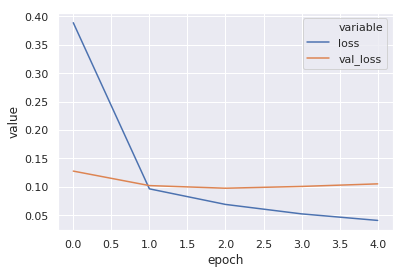

In [10]:
# Load training log file
log_file = join(paths['log_dir'], 'training.log')
train_results = pd.read_csv(log_file, delimiter=',')
train_results.drop(columns=['acc', 'val_acc'], inplace=True)
train_results = pd.melt(train_results, id_vars=['epoch'])
# Plot loss values
sns.lineplot(x='epoch', y='value', hue='variable',data=train_results)
plt.show()

Percebe-se que a partir da primeira época o modelo já começa a possuir um comportamento associado ao _overfitting_, ou seja, o erro de treinamento passa a ser inferior ao erro de validação. Porém como a distância entre os dois erros ainda é pequena, da ordem de $10^{-2}$, o modelo continua a treinar até a época $5$.

### Resultados da fase de teste



A fim de verificar a performance do nosso modelo, vamos aplicá-lo na nossa base de teste. A acurácia de cada _tag_ será estudada separadamente. Primeiramente, no entanto, é necessária a definição de uma função que retorne o resultado da predição (que estará no formato _One-Hot Encoded_) para o formato de palavras. Esta função é definida abaixo.

In [11]:
def decode(sequences, index2tag):
    """ Convert a One-Hot Encoded array into an array of tags,
    using the index2tag dictionary
    Arguments:
        sequences {numpy.array} -- ndimensional array containing
        the one-hot encoded tags
        index2tag {dict} -- dictionary mapping index to tags
    Returns:
        token_sequences {list} -- list of lists containing tags
    """
    return [list(map(lambda cat: index2tag[np.argmax(cat)],
                     categorical_sequence))
            for categorical_sequence in sequences]

O objetivo desta seção é apresentar os resultados das predições realizadas pelo modelo no _dataset_ de teste. Inicialmente, é interessante conhecer a distribuição das etiquetas neste dataset, para relacionar os resultados das predições com este número. O gráfico abaixo apresenta a distribuição das tags:

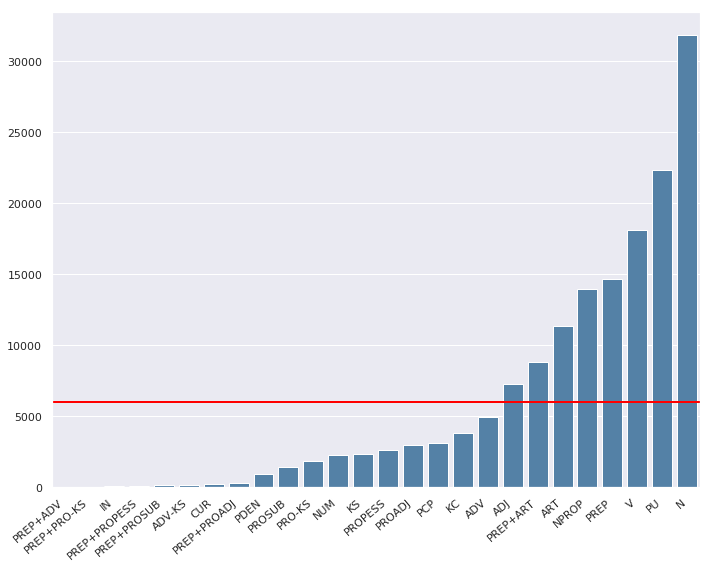

In [12]:
# Fetch tag2index dictionary
std_sentence_size, tag2index = get_file_info(metadata=True)
# Reverse tag2index into index2tag
index2tag = {i: t for t, i in tag2index.items()}
# Decode y_test
decoded_ytest = decode(y_test, index2tag)
unique_tags = np.array(list_flatten(list(decoded_ytest)))
unique_tags = np.delete(unique_tags,
                        np.where((unique_tags == '<PAD>') |
                                 (unique_tags == '<END>')))
unique_tags, counts = np.unique(unique_tags,
                                return_counts=True)
# Increase the size of the figure
plt.figure(figsize=(10, 8))
# Obtain upper case tags
unique_tags = np.array(list(map(lambda x: x.upper(),
                                unique_tags)))
# Sort the tags by frequency
sorted_tags = unique_tags[np.argsort(counts)]
ax = sns.barplot(x=unique_tags,
                 y=counts,
                 order=sorted_tags,
                color='steelblue')
ax.set_xticklabels(ax.get_xticklabels(),
                   rotation=40,
                   ha='right')
mean_count = np.mean(counts)
# Plotting a reference line with the mean
plt.axhline(mean_count,
            linewidth=2,
            color='red')
plt.tight_layout()

Podemos ver que a distribuição de _tags_ é muito desigual. A linha vermelha mostra a media entre as contagens das tags. É interessante observar que as _tags_ mais populares são as de __pontuação__, __nome__, __verbo__ e __preposição__, e as menos populares são __preposição+advérbio__, __preposição + pronome conectivo subortinativo__, __interjeição__, e __preposição+pronome pessoal__.

A fim de se testar a acurácia do modelo, recuperamos o modelo já treinado do disco, e o carregamos na memória. 

In [13]:
# Retrieve model from disk
model = train_neural_network()

Loading weights from word2vec model
Loading word2vec model weights from pickle


Realizando a predição e convertendo os valores de numéricos para categóricos:

In [14]:
# Make prediction from Test Data
yhat = model.predict(X_test)
# Decode yhat
decoded_yhat = decode(yhat, index2tag)

Importando o modelo _Word2Vec_ para decodificação das palavras no _dataset_.

In [15]:
# import word2vec model for converting word indexes to words
wv_model = import_word2vec_model(weights=False)

Loading word2vec model
Loading word2vec model from pickle
Testando se adicionou as tags <PAD>, <END> e <OOV>
PAD 929606
END 929607
OOV 929608


O próximo passo é interpretar o resultado. Define-se uma matriz _results_ da seguinte maneira: $results = \{y\_predito, y\_real, predição\_correta\}$. 

In [16]:
results = []
for index, sentence in enumerate(X_test):
    for idx, word in enumerate(sentence):
        # Remove prediction for Padding and Ending symbols
        if idx2word(word, wv_model=wv_model) != '<PAD>' and idx2word(word, wv_model=wv_model) != '<END>' :
            tmp = [decoded_yhat[index][idx],
                   decoded_ytest[index][idx],
                   decoded_yhat[index][idx] ==
                   decoded_ytest[index][idx] ]
            results.append(tmp)
results = pd.DataFrame(results, columns=['yhat', 'y_test', 'correct'])

Em seguida definimos a matriz $perc$ que contém a porcentagem de acertos para cada etiqueta. 

In [17]:
# Group by tag and take stats for the correct variable
perc = results.groupby(['y_test'])['correct'].describe()
# Calculate correct prediction percentage for each tag
perc['percentage'] = perc['freq']/perc['count']
# Convert tags back to uppercase
perc.index  = perc.index.str.upper()
perc['tag'] = perc.index
# Sort results by percentage
perc.sort_values(by='percentage')

,count,unique,top,freq,percentage,tag
y_test,,,,,,
IN,97,2,True,62,0.639175,IN
ADV-KS,191,2,True,129,0.675393,ADV-KS
PREP+PROSUB,141,2,True,104,0.737589,PREP+PROSUB
PREP+ADV,29,2,True,24,0.827586,PREP+ADV
PROSUB,1430,2,True,1184,0.827972,PROSUB
NPROP,13964,2,True,11709,0.838513,NPROP
PREP+PRO-KS,47,2,True,40,0.851064,PREP+PRO-KS
KS,2327,2,True,1986,0.853459,KS
ADV,4936,2,True,4267,0.864465,ADV


Pode-se observar que as etiquetas que obtiveram a menor taxa de acerto foram: _IN_ (Interjeição) $63.91\%$ e _ADV-KS_ $67.53\%$ (Advérbio Conectivo Subordinativo). As etiquetas que obtiveram a maior taxa de acerto foram: _CUR_ Símbolo de Moeda Corrente (com $99.6\%$) e _PU_ Pontuação (com $99.4\%$). É interessante observar que a porcentagem de acertos não está diretamente relacionada com a frequência da etiqueta no dataset, pois uma das tags com maior taxa de acerto (_CUR_) é uma das menos populares. Abaixo apresenta-se um gráfico com os valores de acurácia apresentados na tabela acima. A linha vermelha indica a pocentagem média atingida pelo modelo. 

Acurácia média:  90.04307154365938%


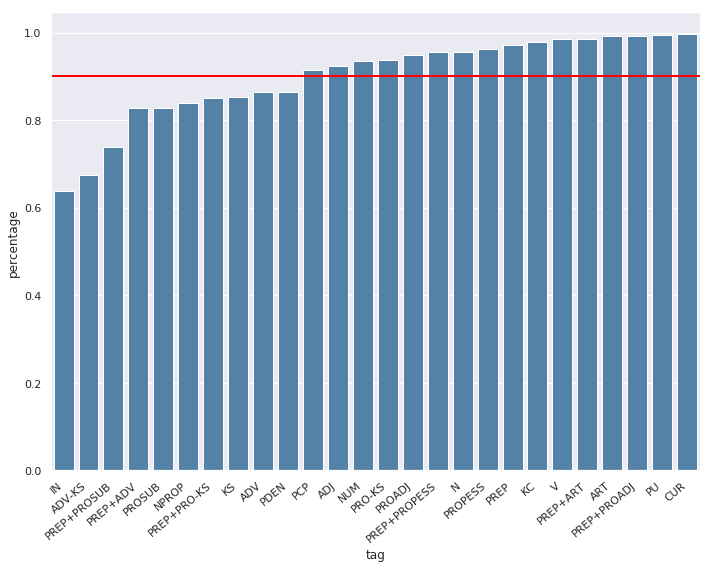

In [18]:
# Set larger figure size
plt.figure(figsize=(10, 8))
# Calculate mean percentage
mean_percentage = np.mean(perc['percentage'])
print('Acurácia média: ', str(mean_percentage*100) + '%')
ax = sns.barplot(x='tag',
                 y='percentage',
                 color='steelblue',
                 order=perc['percentage'].sort_values().index,
                 data=perc)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha='right')
# Plotting a reference line with the mean
plt.axhline(mean_percentage,
            linewidth=2,
            color='red')
plt.tight_layout()

Apesar de ser uma medida da qualidade da predição de um modelo de classificação, a acurácia não é a única métrica que deve ser utilizada. A acurácia mede o numero de elementos atribuídos a uma classe que realmente pertencem àquela classe. Um outro nome para esta métrica é "precisão". Entretanto, esta métrica não considera o número de elementos de cada classe, que foi classificado corretamente em sua classe original. Esta medida possui o nome de "__recall__" (também conhecida como "revocação" ou "sensibilidade"). [[11](https://developers.google.com/machine-learning/crash-course/classification/precision-and-recall)]

A F1-score é a média ponderada da precisão e da sensibilidade. Quanto maior o F1-score, melhor é a capacidade de classificação do modelo. Abaixo é demonstrada uma tabela que calcula as três métricas citadas acima para o modelo proposto.

In [19]:
# Print metrics to our model score
rep = classification_report(results['y_test'],
                            results['yhat'],
                            output_dict=True)
score_results = pd.DataFrame(rep).drop(columns=['macro avg',
                                                'weighted avg',
                                                'micro avg']).transpose()
print(score_results.sort_values(by='f1-score'))
mean_f1score = np.mean(score_results['f1-score'])
print('F1-Score médio: ', str(mean_f1score*100) + '%')

              f1-score  precision    recall  support
in            0.508197   0.421769  0.639175     97.0
adv-ks        0.754386   0.854305  0.675393    191.0
prep+prosub   0.809339   0.896552  0.737589    141.0
prep+pro-ks   0.851064   0.851064  0.851064     47.0
prosub        0.853641   0.880952  0.827972   1430.0
pden          0.865323   0.865323  0.865323    943.0
ks            0.872009   0.891382  0.853459   2327.0
nprop         0.880144   0.926125  0.838513  13964.0
prep+adv      0.888889   0.960000  0.827586     29.0
adv           0.890257   0.917634  0.864465   4936.0
pro-ks        0.900508   0.865788  0.938128   1891.0
adj           0.905093   0.887904  0.922961   7269.0
pcp           0.933247   0.952177  0.915055   3155.0
num           0.937242   0.939486  0.935009   2308.0
n             0.946638   0.937687  0.955763  31851.0
proadj        0.949592   0.951016  0.948173   3010.0
prep          0.965692   0.958982  0.972496  14689.0
propess       0.967555   0.972438  0.962721   

Percebe-se que as tags _CUR_ e _PU_ continuam na frente, com os melhores f1-scores, e as tags _IN_ e _ADV-KS_ continuam nas últimas posições, com os piores f1-scores.

## Conclusão


A tarefa de _POS tagging_ consiste em associar etiquetas de parte de discurso (_Part-of-Speech_) a cada _token_ em uma sentença, indicando a função sintática daquele _token_. Esta marcação é importante em várias outras aplicações, como Desambiguação Semântica de Palavras (_Word Sense Disambiguation_), Reconhecimento de Entidades (_Named Entity Recognition_), Classificação de Sentenças (_Sentence Classification_), entre outros. Uma arquitetura de rede neural interessante para realização desta tarefa são as LSTM. Este tipo de rede é capaz de reconhecer informações em sequências temporais, o que leva a um bom desempenho com sequências de _tokens_. 

O objetivo deste trabalho era construir um modelo baseado em redes neurais recorrentes para a tarefa de _POS Tagging_ em um _corpus_ da língua portuguesa. Construiu-se um modelo utilizando LSTM e obteve-se um resultado final com F1-score médio de $90.5\%$ ($99.2\%$ no melhor caso e $50.81\%$ no pior) e acurácia média de $90.04\%$ ($99.6\%$ no melhor caso e $63.81\%$ no pior). A _tag_ que obteve a maior taxa de acerto e F1-Score foi a _PU_ (pontuação) e a _tag_ que obteve os menores valores para as duas métricas foi _IN_ (interjeição). 


## Referências

* __[[1](http://nilc.icmc.usp.br/macmorpho/macmorpho-manual.pdf)]__ Manual de referência de utilização do _corpus_ MacMorpho. Acesso em: 15/11/2018.
* __[[2](https://arxiv.org/pdf/1301.3781.pdf)]__ Mikolov T, Chen K, Corrado G, Dean J. _Efficient estimation of word representations in vector space_. arXiv preprint arXiv:1301.3781. 2013 Jan 16.
* __[[3](ftp://ftp.cs.wisc.edu/machine-learning/shavlik-group/torrey.handbook09.pdf)]__ Torrey L, Shavlik J. _Transfer learning_. In _Handbook of Research on Machine Learning Applications and Trends: Algorithms, Methods, and Techniques_ 2010 (pp. 242-264). IGI Global.
* __[[4](https://machinelearningmastery.com/transfer-learning-for-deep-learning/)]__ A Gentle Introduction to Transfer Learning for Deep Learning. MachineLearningMastery. Acessado em 22/11/2018.
* __[[5](https://nlpforhackers.io/lstm-pos-tagger-keras/)]__ _Build a POS Tagger with an LSTM using Keras_. Acesso em 14/11/2018.
* __[[6](http://www.bioinf.jku.at/publications/older/2604.pdf)]__ Hochreiter S, Schmidhuber J. _Long short-term memory_. _Neural computation_. 1997 Nov 15;9(8):1735-80.
* __[[7](https://arxiv.org/pdf/1510.06168.pdf)]__ Wang P, Qian Y, Soong FK, He L, Zhao H. _Part-of-speech tagging with bidirectional long short-term memory recurrent neural network. arXiv preprint_ arXiv:1510.06168. 2015 Oct 21.
* __[[8](https://arxiv.org/pdf/1512.05287.pdf)]__ Gal Y, Ghahramani Z. _A theoretically grounded application of dropout in recurrent neural networks_. In _Advances in neural information processing systems_ 2016 (pp. 1019-1027).
* __[[9](https://ml-cheatsheet.readthedocs.io/en/latest/loss_functions.html)]__ _Loss Functions Cheat Sheet_. 
* __[[10](https://openreview.net/pdf?id=ryQu7f-RZ)]__ Reddi SJ, Kale S, Kumar S. _On the convergence of adam and beyond_. 2018.
* __[[11](https://developers.google.com/machine-learning/crash-course/classification/precision-and-recall)]__  _Classification: Precision and Recall_. Microsoft Machine Learning. Acesso em 22/11/2018
